In [1]:
%load_ext autoreload
%autoreload 2

# BLAZHKO ANALYSIS

---

In [2]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML
from astroML.datasets import fetch_LINEAR_sample
from astropy.timeseries import LombScargle
from astroML.datasets import fetch_LINEAR_sample
from astroML.datasets import fetch_LINEAR_geneva
from astropy.timeseries import TimeSeries
from astropy.table import Table
from astroML.time_series import MultiTermFit

# ZTF
from ztfquery import lightcurve

# Basic libraries
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm

# CONFIGURATION
# -------------
sns.set_theme() # setting the theme for plotting
sys.path.insert(0,'../src/')
np.random.seed(42)

# configuring plotting colors
colors = ['#5F6372', '#79A8A4', '#B2AD8F', '#92A186', '#AD8082']
blue = '#5F6372'
turqoise = '#79A8A4'
light_green = '#B2AD8F'
green = '#92A186'
pink = '#AD8082'
cmap = mcolors.ListedColormap(colors)

# configuring fonts for plotting
font = FontProperties()
font.set_family('avenir')
font.set_name('Big Caslon')
font.set_style('normal')
font.set_size('xx-large')


%matplotlib inline  

In [3]:
#| code-fold: false
# Importing custom libraries
# ----------------------------
from data_access import*
from helper import*
from RR_lyrae_params import*
from blazhko_analysis import*
from BE_plotting import*

In [4]:
#| code-fold: false
# LINEAR DATA
# ------------
dataL = fetch_LINEAR_sample(data_home='../inputs')

## Importing previous data:

In [5]:
end = 'ffinal'

# DATA from previous notebook
lc_analysis = pd.read_csv("../outputs/LC_ANALYSIS_"+end+".csv")
rrlyrae = pd.read_csv('../outputs/Lrrlyr_unprocessed.csv')
periodogr = pickle.load(open("../outputs/periodograms_"+end+".pkl", "rb"))
fits = np.load("../outputs/fits_"+end+".npy", allow_pickle=True)
ztf_data = np.load("../outputs/ztf_data_filter"+end+".npy", allow_pickle=True)

In [6]:
print(lc_analysis.shape)
lc_analysis.head()

(2857, 34)


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,MainPeakZ,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score
0,29848,0.557020,0.557040,0.557030,1.000036,301,3.0,1.4,3.3,1.6,...,1.7952,1.7982,333.3333,0.2573,10.0729,0.37,0.00004,NaN,NaN,NaN
1,50402,0.643303,0.643294,0.643298,0.999986,284,0.6,0.7,0.6,0.7,...,1.5545,1.5918,26.8420,0.0027,8.9208,0.21,0.00001,NaN,NaN,NaN
2,62892,0.530776,0.530785,0.530780,1.000017,276,1.1,0.9,1.1,1.0,...,1.8840,1.9433,16.8634,0.0048,13.1609,0.02,0.00002,NaN,NaN,NaN
3,91437,0.674733,0.674737,0.674735,1.000006,177,2.8,1.3,2.8,1.3,...,1.4821,1.4849,355.8719,0.0233,16.1566,0.34,0.00001,NaN,NaN,NaN
4,95250,0.313870,0.313876,0.313873,1.000019,222,0.8,0.8,0.9,0.8,...,3.1860,3.1889,342.4658,0.0028,13.4528,0.02,0.00002,NaN,NaN,NaN


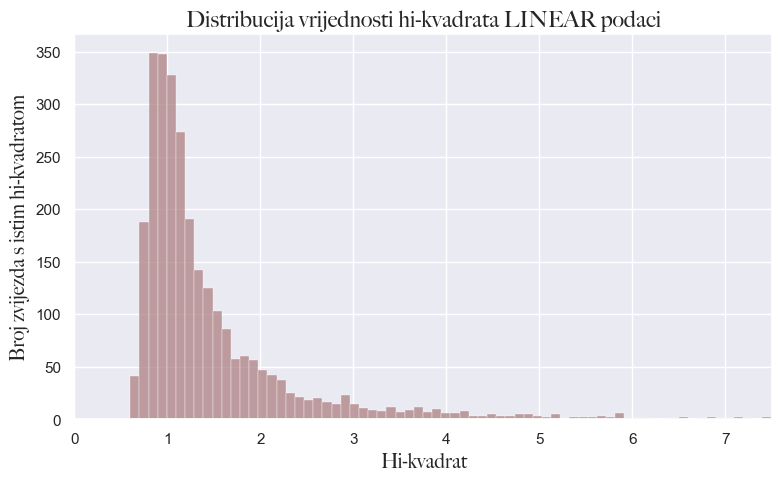

In [65]:
# CHI2 graph
# ============

plt.figure(figsize=(9,5))
sns.histplot(data=lc_analysis['L_chi2dofR'].to_numpy(),color=pink) # drawing a histogram of the distribution of measurements
plt.xlim([0,7.5])
plt.title('Distribucija vrijednosti hi-kvadrata LINEAR podaci', fontproperties=font,fontsize=16)
plt.xlabel('Hi-kvadrat', fontproperties=font, fontsize=14)
plt.ylabel('Broj zvijezda s istim hi-kvadratom', fontproperties=font,fontsize=14)
plt.savefig('../images/dist1.png', dpi=650)
plt.show()

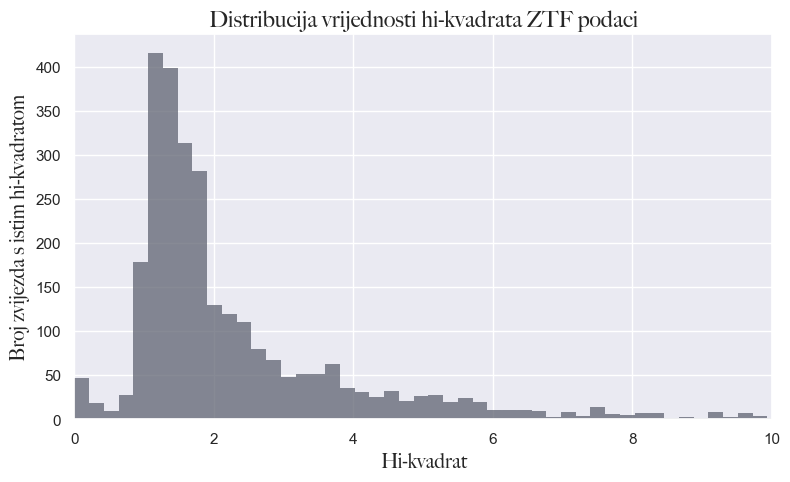

In [69]:
# CHI2 graph
# ============

plt.figure(figsize=(9,5))
sns.histplot(data=lc_analysis['Zchi2dofR'].to_numpy(),color=blue) # drawing a histogram of the distribution of measurements
plt.xlim([0,10])
plt.title('Distribucija vrijednosti hi-kvadrata ZTF podaci', fontproperties=font,fontsize=16)
plt.xlabel('Hi-kvadrat', fontproperties=font, fontsize=14)
plt.ylabel('Broj zvijezda s istim hi-kvadratom', fontproperties=font,fontsize=14)
plt.savefig('../images/dist2.png', dpi=650)
plt.show()

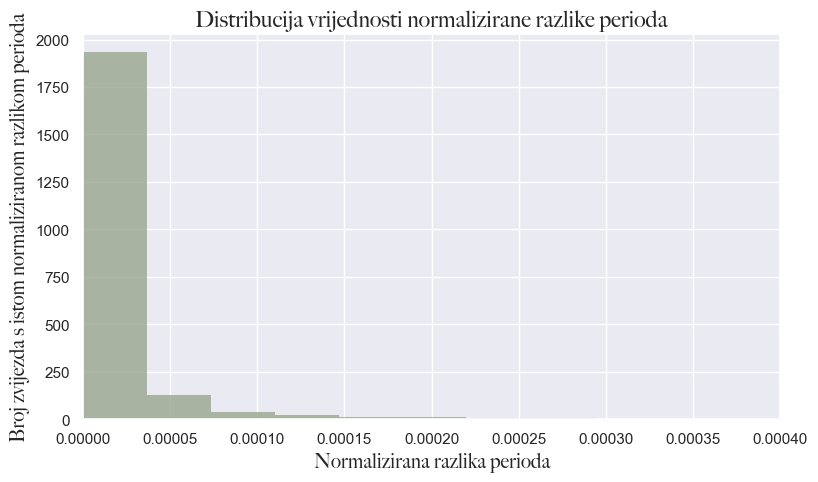

In [68]:
# Period difference graph
# ============

plt.figure(figsize=(9,5))
sns.histplot(data=lc_analysis['dP'].to_numpy(),color=green) # drawing a histogram of the distribution of measurements
plt.xlim([0,0.0004])
plt.title('Distribucija vrijednosti normalizirane razlike perioda', fontproperties=font,fontsize=16)
plt.xlabel('Normalizirana razlika perioda', fontproperties=font, fontsize=14)
plt.ylabel('Broj zvijezda s istom normaliziranom razlikom perioda', fontproperties=font,fontsize=14)
plt.savefig('../images/dist3.png', dpi=650)
plt.show()

# Step 01: BLAZHKO CANDIDATE ALGORITHM

---

In [27]:
blazhko_can = pd.DataFrame(())
blazhko_can = blazhko_determine(lc_analysis, blazhko_can)
blazhko_can.to_csv("../outputs/blazhko_can"+end+".csv", index=False)

In [28]:
print(blazhko_can.shape)
blazhko_can.head(10)

(239, 35)


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,period_vs_amp
0,29848,0.557020,0.557040,0.557030,1.000036,301,3.0,1.4,3.3,1.6,...,1.7982,333.3333,0.2573,10.0729,0.37,0.00004,NaN,Z,6.0,period
1,158779,0.609207,0.609189,0.609198,0.999970,293,3.7,1.6,4.3,1.6,...,1.6444,350.2627,0.0123,16.5371,0.21,0.00003,NaN,Z,6.0,period
2,263541,0.558218,0.558221,0.558220,1.000005,270,15.8,2.9,16.2,3.0,...,1.8025,89.9685,0.0021,7.5968,0.18,0.00001,NaN,Z,7.0,amp
3,514883,0.557723,0.557737,0.557730,1.000025,289,5.3,1.7,5.4,1.6,...,1.7958,357.1429,0.0149,17.9476,0.17,0.00003,NaN,Z,7.0,period
4,523832,0.372376,0.372384,0.372380,1.000021,251,1.8,1.2,1.9,1.3,...,2.7122,37.3413,0.1528,6.3617,0.17,0.00002,Z,NaN,NaN,NaN
5,737951,0.357023,0.357023,0.357023,1.000000,273,6.0,2.2,6.0,2.2,...,2.8039,332.2259,0.0020,13.7006,0.09,0.00000,NaN,Z,6.0,amp
6,803829,0.595281,0.595286,0.595284,1.000008,270,8.7,2.3,9.7,2.7,...,1.6828,335.5705,0.0082,17.8498,0.43,0.00001,NaN,Z,10.0,amp
7,810169,0.465185,0.465212,0.465198,1.000058,289,6.0,2.1,8.2,2.3,...,2.2230,13.6082,0.0077,16.1490,0.02,0.00006,NaN,Z,12.0,period
8,880588,0.600138,0.600134,0.600136,0.999993,295,3.2,1.2,3.3,1.2,...,1.6736,136.4256,0.0109,14.7971,0.07,0.00001,L,NaN,NaN,NaN
9,924301,0.507503,0.507440,0.507472,0.999876,418,13.8,1.9,35.3,3.8,...,1.9763,178.4121,0.0219,18.8612,0.08,0.00012,NaN,Z,10.0,period


# Step 02: VISUAL ANALYSIS

---

In [29]:
# ZTF PERIODOGRAM
# =================
ztf_per = category_analysis(blazhko_can, fits, periodogr, ztf_data, dataL, 'ztf_periodogram',id_list=None,parameter='IndicatorType', value='Z')

This dataset has 20 stars.


In [30]:
blazhko_analyzer = ztf_per.get_save_data()
end = 'ztf_periodogram'
blazhko_analyzer.to_csv("../outputs/blazhko_list_"+end+".csv", index=False)

print(blazhko_analyzer.shape)

(11, 35)


In [31]:
# LINEAR PERIODOGRAM
# ======================
linear_per = category_analysis(blazhko_can, fits, periodogr, ztf_data, dataL, 'linear_periodogram',id_list=None,parameter='IndicatorType', value='L')

This dataset has 30 stars.


In [32]:
blazhko_analyzerl = linear_per.get_save_data()
end = 'linear_periodogram'
blazhko_analyzerl.to_csv("../outputs/blazhko_list_"+end+".csv", index=False)

print(blazhko_analyzerl.shape)

(13, 35)


In [33]:
# ZTF CHI2
# ==========
ztf_chi = category_analysis(blazhko_can, fits, periodogr, ztf_data, dataL, 'ztf_chi',id_list=None,parameter='ChiType', value='Z')

This dataset has 166 stars.


In [36]:
blazhko_analyzerzc = ztf_chi.get_save_data()
end = 'ztf_chi'
blazhko_analyzerzc.to_csv("../outputs/blazhko_list_"+end+".csv", index=False)

print(blazhko_analyzerzc.shape)

(101, 35)


In [37]:
# LINEAR CHI2
# ==========
linear_chi = category_analysis(blazhko_can, fits, periodogr, ztf_data, dataL, 'linear_chi',id_list=None,parameter='ChiType', value='L')

This dataset has 18 stars.


In [38]:
blazhko_analyzerlc = linear_chi.get_save_data()
end = 'linear_chi'
blazhko_analyzerlc.to_csv("../outputs/blazhko_list_"+end+".csv", index=False)

print(blazhko_analyzerlc.shape)

(8, 35)


In [45]:
be_other = blazhko_can[(blazhko_can['IndicatorType']!= 'Z') & (blazhko_can['IndicatorType']!= 'L')&(blazhko_can['ChiType']!='Z')&(blazhko_can['ChiType']!='L')]
be_other = be_other.reset_index(drop=True)
print(be_other.shape)
be_other.head()

(5, 35)


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,period_vs_amp
0,2714034,0.610868,0.610800,0.610834,0.999889,536,2.4,1.5,6.4,1.9,...,1.6427,182.6484,0.0343,14.0620,0.08,0.00011,NaN,NaN,5.0,period
1,3405178,0.579231,0.579204,0.579218,0.999953,256,1.1,1.0,3.7,1.3,...,1.7319,185.1852,0.0031,14.3561,0.31,0.00005,NaN,NaN,6.0,period
2,5592590,0.346945,0.346980,0.346962,1.000101,603,2.3,1.2,12.7,3.5,...,2.9438,16.1799,0.0338,7.1460,0.06,0.00010,NaN,NaN,5.0,period
3,8799313,0.327560,0.327542,0.327551,0.999945,280,1.3,1.1,1.8,1.1,...,3.0565,289.8551,0.0021,11.9305,0.07,0.00005,NaN,NaN,5.0,period
4,22924523,0.583239,0.583138,0.583188,0.999827,308,1.4,1.1,16.0,2.5,...,1.7177,347.8261,0.0621,13.0708,0.36,0.00017,NaN,NaN,6.0,period


In [46]:
BE_candidates_other = category_analysis(be_other, fits, periodogr, ztf_data, dataL, 'other')

This dataset has 5 stars.


In [47]:
blazhko_analyzerother = BE_candidates_other.get_save_data()
end = 'other'
blazhko_analyzerother.to_csv("../outputs/blazhko_list_"+end+".csv", index=False)

print(blazhko_analyzerother.shape)

(3, 35)


---

In [48]:
BE_LIST = list(blazhko_analyzerlc['LINEAR id']) + list(blazhko_analyzerzc['LINEAR id']) + list(blazhko_analyzerl['LINEAR id']) + list(blazhko_analyzer['LINEAR id']) + list(blazhko_analyzerother['LINEAR id'])
BE_LIST = set(BE_LIST)
print(len(BE_LIST))

136


In [49]:
print(*BE_LIST, sep=', ')

9979905, 7279621, 1876491, 5592590, 23135759, 2455568, 16991760, 21488669, 21874209, 3140139, 9532981, 523832, 22959674, 158779, 1390653, 7580734, 10503746, 10662468, 8610884, 7283275, 2122319, 8799313, 2248787, 1240665, 1748058, 3219035, 3048546, 2243683, 3294319, 2397296, 1736308, 2936953, 7048826, 2041979, 6651516, 6819457, 3036295, 24020106, 9852554, 2892940, 924301, 1435279, 1092244, 2766997, 29848, 17544856, 5931160, 3437725, 737951, 22244513, 3196582, 4101289, 17247918, 9961135, 2334384, 5272753, 3183285, 2812086, 22828215, 810169, 22980793, 4586691, 1212611, 7827663, 8311517, 6967017, 11215595, 4320492, 17275627, 7846640, 1882354, 9236215, 2414841, 8343291, 23653629, 10030349, 2742032, 7254801, 7344401, 10814742, 9063194, 23898397, 2653982, 17185566, 7811366, 8907563, 1307948, 2075949, 9968431, 23596342, 19775800, 8222011, 21806402, 514883, 4804945, 23148883, 8331094, 9918809, 10260828, 10420063, 8036191, 1857382, 2229607, 1448299, 3196780, 22518636, 2612592, 263541, 9449335, 7

In total we have 136 Blazhko stars!!

---

In [50]:
FINAL_BE_CATALOGUE = pd.DataFrame()
FINAL_BE_CATALOGUE = pd.concat([FINAL_BE_CATALOGUE, blazhko_analyzer.reset_index(drop=True)],ignore_index=True, axis=0)
FINAL_BE_CATALOGUE = pd.concat([FINAL_BE_CATALOGUE, blazhko_analyzerzc.reset_index(drop=True)],ignore_index=True, axis=0)
FINAL_BE_CATALOGUE = pd.concat([FINAL_BE_CATALOGUE, blazhko_analyzerl.reset_index(drop=True)],ignore_index=True, axis=0)
FINAL_BE_CATALOGUE = pd.concat([FINAL_BE_CATALOGUE, blazhko_analyzerlc.reset_index(drop=True)],ignore_index=True, axis=0)
FINAL_BE_CATALOGUE = pd.concat([FINAL_BE_CATALOGUE, blazhko_analyzerother.reset_index(drop=True)],ignore_index=True, axis=0)

print(FINAL_BE_CATALOGUE.shape)
FINAL_BE_CATALOGUE.head()

(136, 35)


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,period_vs_amp
0,523832,0.372376,0.372384,0.372380,1.000021,251,1.8,1.2,1.9,1.3,...,2.7122,37.3413,0.1528,6.3617,0.17,0.00002,Z,NaN,NaN,NaN
1,1240665,0.632528,0.632522,0.632525,0.999991,468,25.2,3.0,25.4,2.9,...,1.5865,182.3154,0.0570,15.9957,0.00,0.00001,Z,NaN,NaN,NaN
2,1736308,0.555848,0.555843,0.555846,0.999991,372,2.9,1.3,3.0,1.2,...,1.8264,36.6367,0.0529,5.6501,0.11,0.00001,Z,NaN,NaN,NaN
3,2669011,0.591153,0.591151,0.591152,0.999997,450,2.4,1.1,2.3,1.1,...,1.7015,101.2146,0.0751,6.5360,0.16,0.00000,Z,NaN,NaN,NaN
4,2742032,0.629676,0.629692,0.629684,1.000025,514,1.8,0.9,1.9,1.0,...,1.5956,133.2445,0.0602,7.4751,0.34,0.00003,Z,NaN,NaN,NaN


In [51]:
FINAL_BE_CATALOGUE.to_csv('../outputs/FINAL_BE_CATALOGUE.csv', index=False)

---

In [52]:
SHOWCASE_Catalogue1 = pd.DataFrame()
SHOWCASE_Catalogue1['LINEAR id'] = FINAL_BE_CATALOGUE['LINEAR id']
SHOWCASE_Catalogue1['LINEAR period'] = FINAL_BE_CATALOGUE['Plinear']
SHOWCASE_Catalogue1['ZTF period'] = FINAL_BE_CATALOGUE['Pztf']
SHOWCASE_Catalogue1['LINEAR hi-kvadrat'] = FINAL_BE_CATALOGUE['L_chi2dofR']
SHOWCASE_Catalogue1['ZTF hi-kvadrat'] = FINAL_BE_CATALOGUE['Zchi2dofR']
SHOWCASE_Catalogue1['LINEAR amplituda'] = FINAL_BE_CATALOGUE['Lampl']
SHOWCASE_Catalogue1['ZTF amplituda'] = FINAL_BE_CATALOGUE['Zampl']
SHOWCASE_Catalogue1['LINEAR glavna frekvencija'] = FINAL_BE_CATALOGUE['MainPeakL']
SHOWCASE_Catalogue1['LINEAR blazhko frekvencija'] = FINAL_BE_CATALOGUE['BlazhkoPeakL']
SHOWCASE_Catalogue1['ZTF glavna frekvencija'] = FINAL_BE_CATALOGUE['MainPeakZ']
SHOWCASE_Catalogue1['ZTF blazhko frekvencija'] = FINAL_BE_CATALOGUE['BlazhkoPeakZ']
SHOWCASE_Catalogue1['LINEAR blazhko period'] = FINAL_BE_CATALOGUE['BlazhkoPeriodL']
SHOWCASE_Catalogue1['ZTF blazhko period'] = FINAL_BE_CATALOGUE['BlazhkoPeriodZ']

In [54]:
SHOWCASE_Catalogue1.head(10)

,LINEAR id,LINEAR period,ZTF period,LINEAR hi-kvadrat,ZTF hi-kvadrat,LINEAR amplituda,ZTF amplituda,LINEAR glavna frekvencija,LINEAR blazhko frekvencija,ZTF glavna frekvencija,ZTF blazhko frekvencija,LINEAR blazhko period,ZTF blazhko period
0,523832,0.372376,0.372384,1.2,1.1,0.42,0.59,2.6855,2.8040,2.6854,2.7122,8.4370,37.3413
1,1240665,0.632528,0.632522,3.0,1.1,0.33,0.33,1.5810,1.6149,1.5810,1.5865,29.4942,182.3154
2,1736308,0.555848,0.555843,1.3,1.0,0.70,0.59,1.7991,1.8330,1.7991,1.8264,29.4377,36.6367
3,2669011,0.591153,0.591151,1.1,0.7,0.66,0.50,1.6916,1.7256,1.6916,1.7015,29.4464,101.2146
4,2742032,0.629676,0.629692,0.9,1.4,0.55,0.89,1.5881,1.6221,1.5881,1.5956,29.4681,133.2445
5,2812086,0.646015,0.646000,3.0,3.2,0.61,0.58,1.5480,1.5781,1.5480,1.5519,33.1730,258.7322
6,3507643,0.801141,0.801132,1.6,0.9,0.37,0.43,1.2482,1.2821,1.2482,1.2538,29.5290,181.1594
7,5931160,0.664700,0.664708,0.8,1.1,0.35,0.33,1.5044,1.5383,1.5044,1.5078,29.5421,293.6858
8,6665721,0.643318,0.643325,1.0,1.7,0.46,0.45,1.5544,1.5883,1.5544,1.5669,29.5159,79.9680
9,17185566,0.614160,0.614169,1.5,1.9,0.40,0.42,1.6282,1.6620,1.6282,1.6365,29.5814,120.6273


In [59]:
incidence_rate = SHOWCASE_Catalogue1.shape[0]/2914
print(f'The incidence rate of Blazhko stars in our sample of stars is:{round(incidence_rate*100, 2)}%')

The incidence rate of Blazhko stars in our sample of stars is:4.67%


In [62]:
algorithm_hit_rate = SHOWCASE_Catalogue1.shape[0]/blazhko_can.shape[0]
print(f'The hit rate of the algorithm is:{round(algorithm_hit_rate*100, 2)}%')

The hit rate of the algorithm is:56.9%


---

## Drawing images for the paper

3183285, 4101289, 6651516, 6819457, 6967017, 7048826, 7344401, 8311517, 8343291, 9968431, 9979905, 10030349, 10260828, 19775800, 22518683

In [64]:
star1 = [4101289]
star2 = [6819457]
star3 = [7048826]
star4 = [10260828]

In [73]:
single = category_analysis(lc_analysis, fits, periodogr, ztf_data, dataL, end='test',id_list=star4, plotSave=True)

This dataset has 1 stars.
